# 0.0 Tools

## 0.1. Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
# import psycopg2 as pg
import scikitplot as skplt
import matplotlib.pyplot as plt
import os
import pickle
import inflection

from scipy                 import stats
from tabulate              import tabulate
from IPython.display       import Image
from IPython.core.display  import HTML

## 0.2. Load dataset

In [2]:
data = pd.read_csv('Data/train.csv')

In [3]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.3. Helper Functions

# 1.0. Data Description

At this stage we will understand how the data is and how big the problem we are facing is.

In [4]:
df1 = data.copy()

## 1.1. Rename Columns

In [5]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
# data dimenstions
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of cols: 12


## 1.3. Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Columns Description

* **id**	Unique ID for the customer
* **Gender**	Gender of the customer
* **Age**	Age of the customer
* **Driving_License**	0 : Customer does not have DL, 1 : Customer already has DL
* **Region_Code**	Unique code for the region of the customer
* **Previously_Insured**	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* **Vehicle_Age**	Age of the Vehicle
* **Vehicle_Damage**	1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* **Annual_Premium**	The amount customer needs to pay as premium in the year
* **Policy_Sales_Channel**	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* **Vintage**	Number of Days, Customer has been associated with the company
* **Response**	1 : Customer is interested, 0 : Customer is not interested

## 1.6. Descriptive Statistical

In [9]:
num_attributes = df1[['age', 'annual_premium', 'vintage']]
cat_attributes = df1[['gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage',
                     'policy_sales_channel']]
target_attributes = df1['response']

### 1.6.1. Numerical Attributes

In [10]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


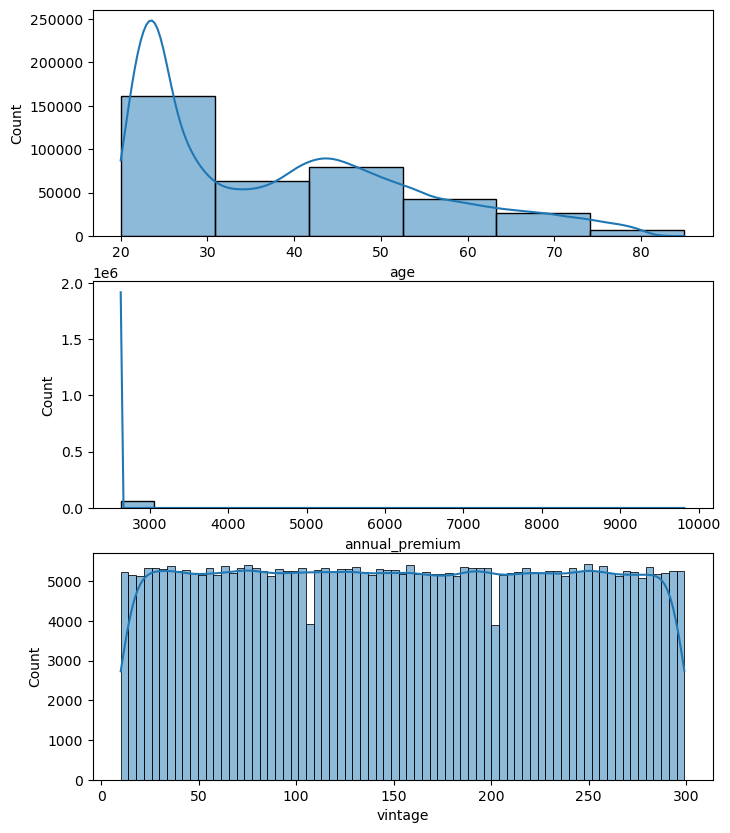

In [11]:
fig, axs = plt.subplots(3, figsize = (8, 10))
sns.histplot(df1['age'], ax=axs[0], bins = 6, kde=True)
sns.histplot(df1[df1['annual_premium']<10000]['annual_premium'], ax=axs[1], kde=True)
sns.histplot(df1['vintage'], ax=axs[2], kde=True);

### 1.6.2. Categorical Attributes

In [12]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender                    2
driving_license           2
region_code              53
previously_insured        2
vehicle_age               3
vehicle_damage            2
policy_sales_channel    155
dtype: int64

<Axes: xlabel='gender', ylabel='count'>

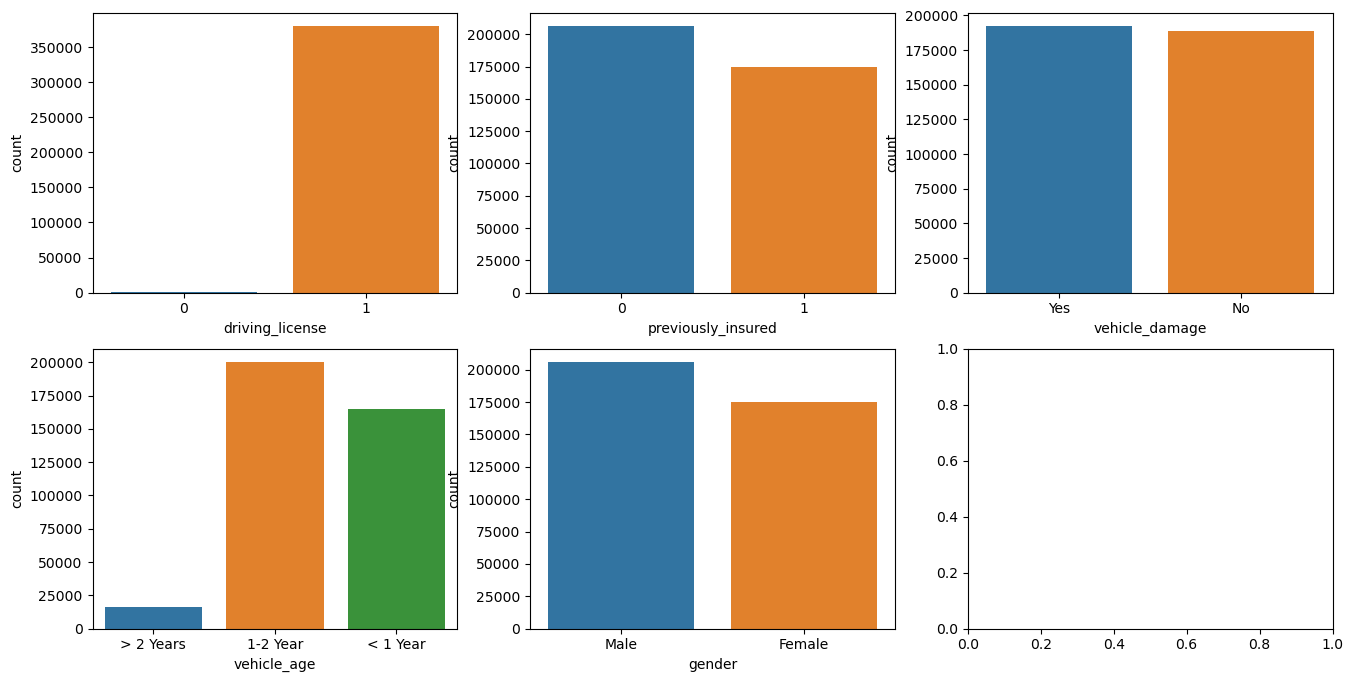

In [13]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (16, 8))

sns.countplot(x = 'driving_license', data = df1, ax=axs[0][0])
sns.countplot(x = 'previously_insured', data = df1, ax=axs[0][1])
sns.countplot(x = 'vehicle_damage', data = df1, ax=axs[0][2])
sns.countplot(x = 'vehicle_age', data = df1, ax=axs[1][0])
sns.countplot(x = 'gender', data = df1, ax=axs[1][1])

<Axes: xlabel='region_code', ylabel='count'>

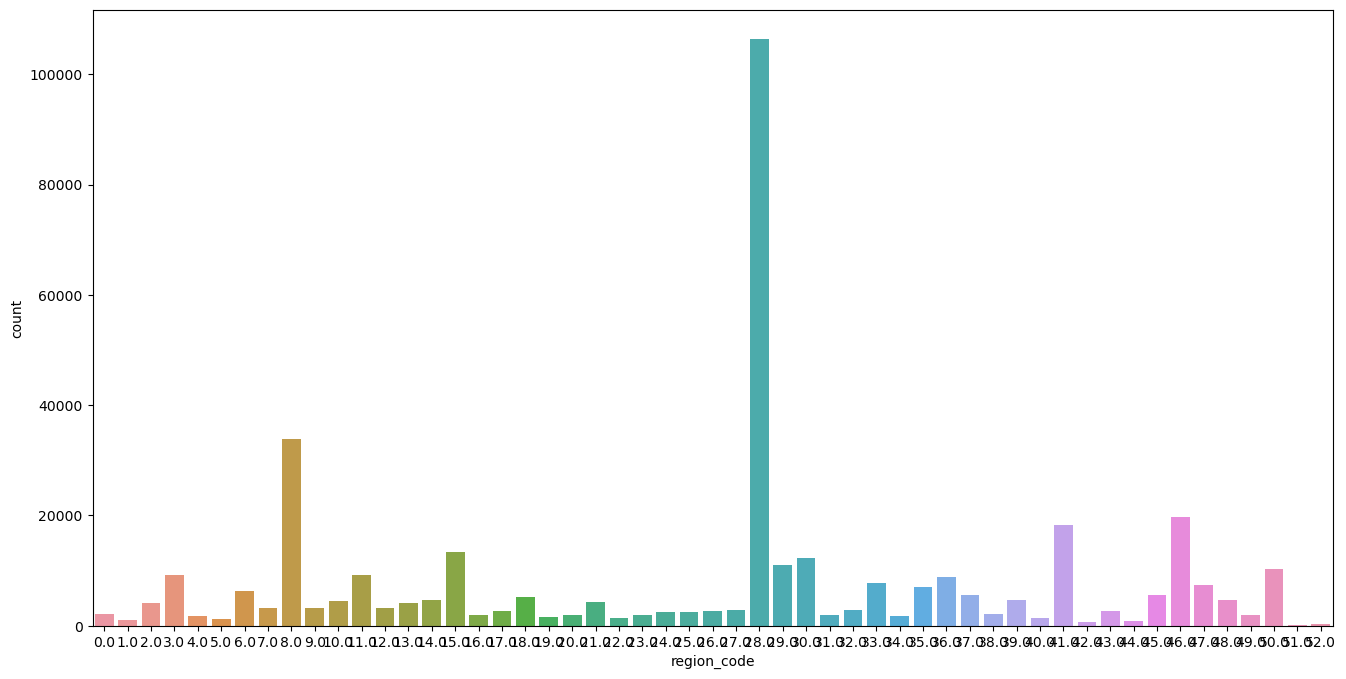

In [14]:
fig, axs = plt.subplots(figsize = (16, 8))
sns.countplot(x = 'region_code', data = df1)

<Axes: xlabel='policy_sales_channel', ylabel='count'>

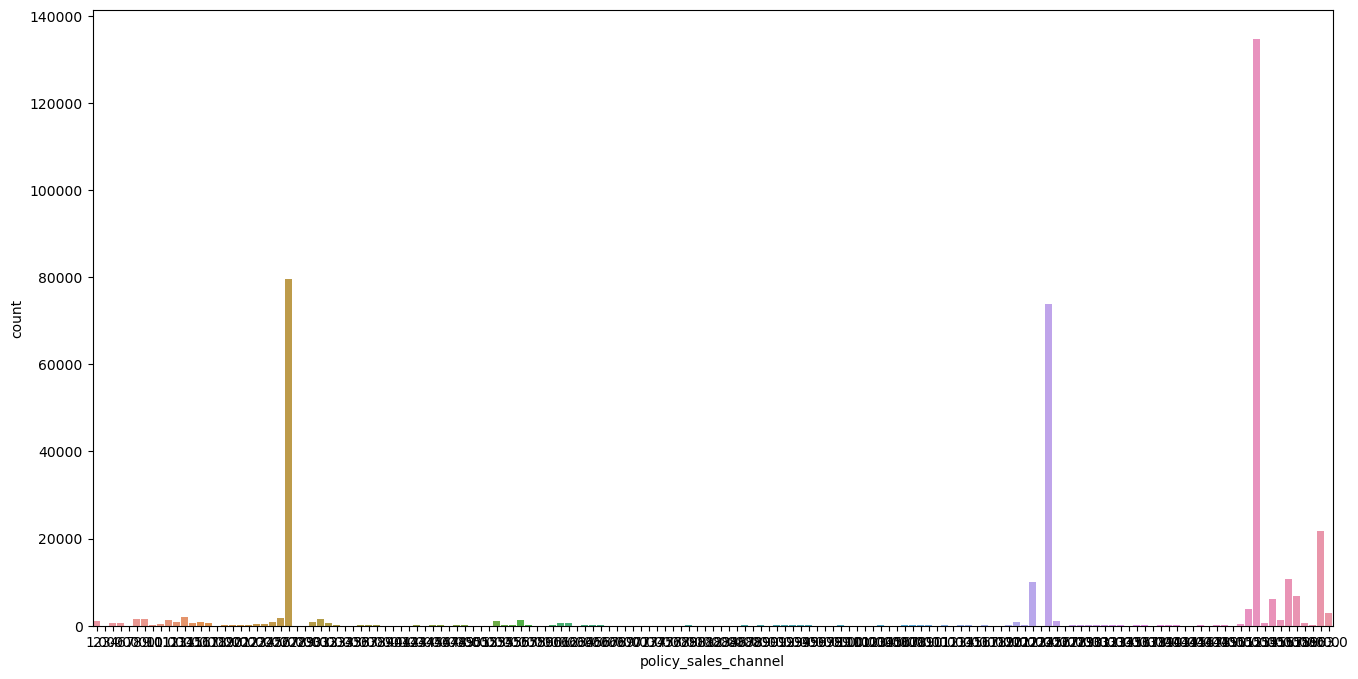

In [15]:
fig, axs = plt.subplots(figsize = (16, 8))
sns.countplot(x = 'policy_sales_channel', data = df1)

In [16]:
# Olhando pros 4 maiores valores:
df1['policy_sales_channel'].value_counts().head(4)

152.0    134784
26.0      79700
124.0     73995
160.0     21779
Name: policy_sales_channel, dtype: int64

### 1.6.3 Target Atribute

<Axes: xlabel='response', ylabel='count'>

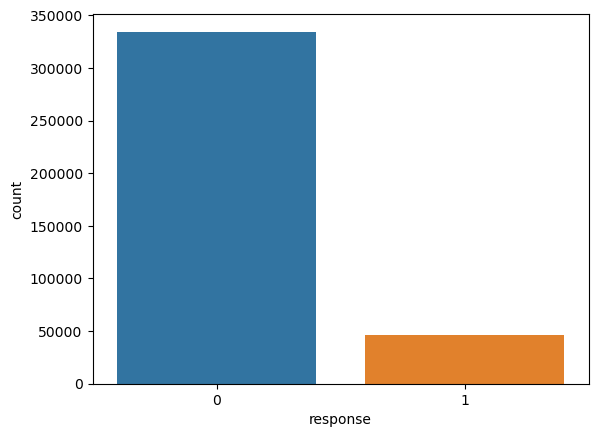

In [17]:
sns.countplot(x = 'response', data = df1)